In [1]:
import pickle
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_performance(true_labels, pred_labels): # metrics
	# ARI: adjusts for chance. 1 = good; 0 = random labelling
	print(f"Kmeans ARI score: {adjusted_rand_score(true_labels, pred_labels):.2f}")

In [3]:
def vectorize_contact_matrix(contact_matrix, include_diag=True):
	"""
	Vectorizes the block-diagonal contact matrix using the upper triangle.
	
	Args:
		contact_matrix (ndarray): Square 4D block matrix of shape (chr_i, chr_j, loc_i, loc_j).
		include_diagonal (bool): Whether to include the diagonal in the vector.
	
	Returns:
		1D np.array of concatenated vectorized intra-chromosome contacts.
	"""
	vectorized = []

	for i in range(23):  # for each chromosome (diagonal block)
	# note: assuming no INTER-chromosomal contact blocks
		block = contact_matrix[i][i]

		if isinstance(block,str) and block == "skip":
			continue
		
		block = np.array(block)
		length = block.shape[0]  # number of loci

		k = 1 # Default is exclude diagonal
		if include_diag:
			k = 0
		triu_indices = np.triu_indices(length, k=k)
		upper_triangle = block[triu_indices]

		vectorized.append(upper_triangle)
		

	# concatenate all chromosomes into one vector in row-major style
	return np.concatenate(vectorized)

In [4]:
my_filepath = 'contact_dict_bin_cells_filtered.pkl'

In [5]:
# load data nested dictionary data file 
# Format contact_dict = {cell_type: {cell_name: dataframe, ...}, ...}
# E.g. {'GM12878': {'cell1.txt': contact_matrix1, 'cell2.txt': contact_matrix2},
#     'K562': {'cell3.txt': contact_matrix3}, ...}
with open(my_filepath, "rb") as f:
	contact_dict = pickle.load(f)

In [6]:
def get_X_labels_lens(contact_dict, include_diag=True):
	"""
	Get overall matrix X for applying dimension reduction
	rows = number of cells (observations), 
	columns = number of contact intersections/"pixels" (features)

	Output: X (np array): (num_cells, num_features)
		cell_labels (list of tuples): (cell_type, cell_name) for each row = cell in X
		labels (list): type of each cell
		chr_lens (list): length (number of loci) for each chromosome
	"""
	# Master matrix and labels
	all_vectors = []
	cell_labels = []
	labels = []
	chr_lens = []

	first_cell = True
	for cell_type, cells in contact_dict.items():
		for cell_name, matrix in cells.items():
			vec = vectorize_contact_matrix(matrix, include_diag=include_diag)
			all_vectors.append(vec)
			cell_labels.append((cell_type, cell_name))
			labels.append(cell_type)	# for coloring cell points by their type
			
			if first_cell: # only need to find chromosome lengths for one cell
				for i in range(23):  # for each chromosome (diagonal block)
					block = matrix[i][i]
					if isinstance(block,str) and block == "skip":
						continue
					block = np.array(block)
					chr_lens.append(block.shape[0])
				first_cell = False

	# convert to np array for efficient masking. Else, kernel will crash
	labels = np.array(labels)
				
	# Stack into a matrix: each row is a vectorized cell
	X = np.vstack(all_vectors)
	return(X, cell_labels, labels, chr_lens)

In [7]:
def get_exponential_distance_weights(chr_lens, alpha=0.9):
    """
        Create weights for vectorized upper-triangular contact matrices (including diagonal),
        where weights grow exponentially with distance from the diagonal.

        Args:
            chr_lens (list): list of chromosome lengths (i.e., number of loci per chromosome).
            alpha (float): exponential base; weight = alpha^distance from diagonal (smaller alpha = faster decay).

        Returns:
            weights (np.array): concatenated weights matching the vectorized contact vector.
        """
    weights = []
    for L in chr_lens:
        # Get upper triangle indices including diagonal
        i, j = np.triu_indices(L, k=0)
        dists = np.abs(j - i)  # distance from diagonal: 0, 1, 2, ...
        w = alpha ** dists     # exponential decay: 1, alpha, alpha^2, ...
        weights.append(w)

    return np.concatenate(weights)

In [8]:
#get labels and chromosome lengths from the contact_dict
if __name__ == "__main__":	# don't run if imported
	X, cell_labels, labels, chr_lens = get_X_labels_lens(contact_dict)
	print("X shape:", X.shape)	# Unfiltered: 2611 cell files, 236562 loci contact pairs
	# display(X)
	
# find weights using the chromosome lengths	
alpha = 0.9 
weights = get_exponential_distance_weights(chr_lens, alpha=alpha)

X shape: (1958, 239611)


In [9]:
#this should be the same length as the number of features in X
weights.shape

(239611,)

In [10]:
#apply weights to X (vectorized contact matrix)
X_weighted = X*np.sqrt(weights)

In [11]:
#perform dimensionality reduction using PCA
X_weighted_pca= PCA(n_components=300).fit_transform(X_weighted)

In [12]:
print("Reduced shape:", X_weighted_pca.shape)

Reduced shape: (1958, 300)


In [13]:
#apply UMAP to the PCA-reduced data (2D)
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    metric="euclidean",
    random_state=42,
)

X_umap_weighted_pca = reducer.fit_transform(X_weighted_pca)

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


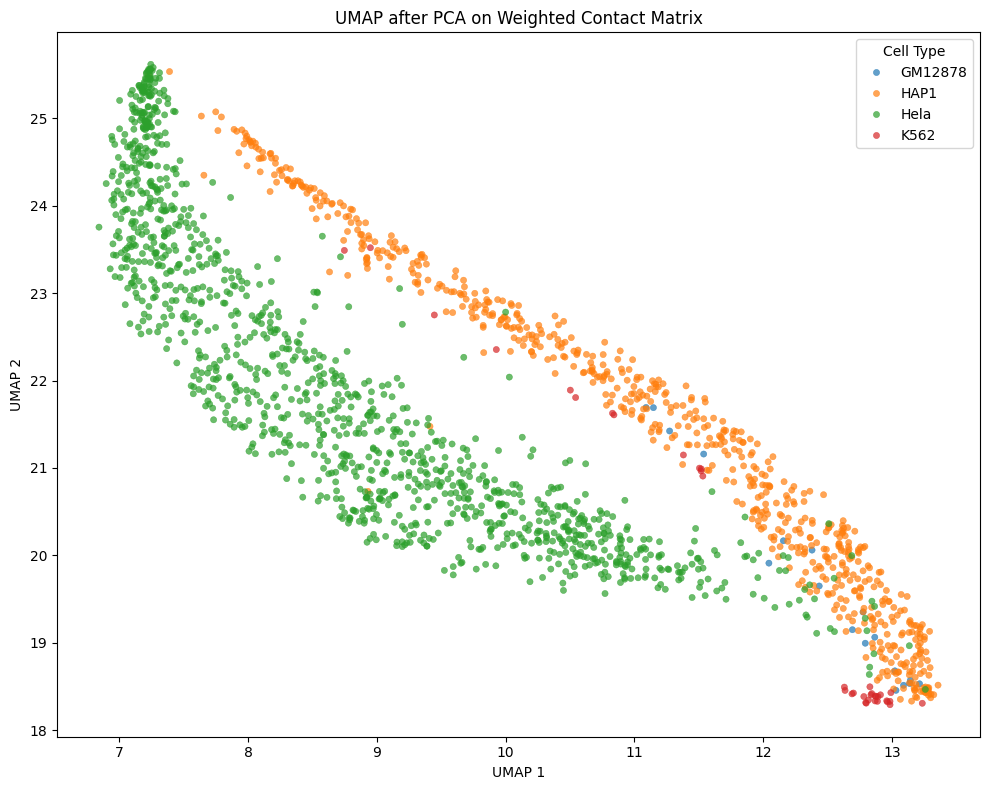

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_labels = np.unique(labels)
palette = sns.color_palette("tab10", len(unique_labels))
color_map = dict(zip(unique_labels, palette))

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap_weighted_pca[:, 0], y=X_umap_weighted_pca[:, 1], hue=labels,
                palette="tab10", s=20, alpha=0.7, edgecolor=None)
plt.title("UMAP after PCA on Weighted Contact Matrix")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", loc='upper right')
plt.tight_layout()
plt.show()

In [15]:
# Use the same cell_labels and labels you extracted earlier
true_labels = [cell_type for (cell_type, cell_name) in cell_labels]

# Encode string labels into integers
le = LabelEncoder()
true_labels_encoded = le.fit_transform(true_labels)

In [16]:
# --- KMeans ---
num_clusters = len(np.unique(true_labels))
kmeans_weighted = KMeans(init="random",n_clusters=num_clusters, 
                         random_state=0,n_init=10)
kmeans_labels_weighted_pred = kmeans_weighted.fit_predict(X_umap_weighted_pca)

# evaluate clustering performance 
evaluate_performance(true_labels, kmeans_labels_weighted_pred)

Kmeans ARI score: 0.10


In [17]:
# --- Spectral Clustering ---
spectral_weighted = SpectralClustering(
    n_clusters=num_clusters,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=42
)
spectral_labels_weighted = spectral_weighted.fit_predict(X_umap_weighted_pca)

evaluate_performance(true_labels, spectral_labels_weighted)

Kmeans ARI score: 0.36
